# Domain Decomposition and Grid Generation
#### (and maybe other things?)

### Building everything you might need for stencil generation

This notebook steps through domain decomposition into tiles, projection of points onto the grid, and building everything else needed for stencil generation later on (e.g., standalone tracer advection).

In addition, it also shows how to retrieve some data (lat, lon, dx, dy) and plot them on a sphere.

The bottom-most cell of this notebook demonstrates how you can reproduce all the steps in this notebook using the functions written in the helper `functions.py` file.

In [1]:
import ipyparallel as ipp

cluster = ipp.Cluster(engines="mpi", n=6).start_and_connect_sync()
%autopx

Starting 6 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/6 [00:00<?, ?engine/s]

%autopx enabled


Setting up configuration parameters for grid generation: layout and number of grid points per tile.

In [2]:
%%capture
nx = 20
ny = 20
nz = 79
""" (int): number of compute domain points per tile in each direction """

nhalo = 3
""" (int): number of halo points in x- and y- directions """

layout = (1, 1)
""" (int, int): how many parts each tile is split into along x- and y- directions """

backend = "numpy"
""" (str): gt4py backend name
    - other options? Untested. """

Initializing Message Passing Interface (MPI) communicator and confirming the number of ranks (mpi_size).

In [3]:
from mpi4py import MPI

mpi_comm = MPI.COMM_WORLD
mpi_size = mpi_comm.Get_size()
mpi_rank = mpi_comm.Get_rank()


## Domain decomposition

Add some text here describing what this portion does. 

Maybe:
At this point, each individual tile doesn't really have any idea that it's on a cubed-sphere.

- `TilePartitioner`: tells the process how tile data is allocated between ranks on a tile, including their orientation with respect to one another;
- `CubedSpherePartitioner`: tells the process how data on the entire cubed sphere is allocated between its ranks, including their orientation with respect to one another;
- `CubedSphereCommunicator`: performs communications on the cubed sphere;
- `SubtileGridSizer`: is able to tell a user how large a local array should be for a given rank, given information about the partitioning of the tile and the full tile size, and given the dimensionality of that variable;
- `QuantityFactory`: creates quantities given a dimensionality and a `SubtileGridSizer` to tell it how large the data needs to be.

In [4]:
%%capture
from pace.util import (
    CubedSphereCommunicator, 
    CubedSpherePartitioner, 
    QuantityFactory, 
    SubtileGridSizer, 
    TilePartitioner
)

partitioner = CubedSpherePartitioner(TilePartitioner(layout))

communicator = CubedSphereCommunicator(mpi_comm, partitioner)

sizer = SubtileGridSizer.from_tile_params(
    nx_tile=nx,
    ny_tile=ny,
    nz=nz,
    n_halo=nhalo,
    extra_dim_lengths={},
    layout=layout,
    tile_partitioner=partitioner.tile,
    tile_rank=communicator.tile.rank,
)

quantity_factory = QuantityFactory.from_backend(
    sizer=sizer, 
    backend=backend
)

%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

## Grid generation

Add some text here describing what this portion does. 

Maybe: 
These construct data to project everything on the cubed-sphere?

- `MetricTerms`: a data container for grid information.

The following are required for tracer advection, because that comes from `fv3core`, but are not part of grid generation.
- `DampingCoefficients`: a data container for damping coefficients (called in FiniteVolumeTransport);
- `GridData`: the data container for grid information used by the dynamical core (called in FiniteVolumeTransport and TracerAdvection stencils);

In [5]:
%%capture
from pace.util.grid import (
    DampingCoefficients, 
    GridData, 
    MetricTerms
)

metric_terms = MetricTerms(
    quantity_factory=quantity_factory, 
    communicator=communicator
)

damping_coefficients = DampingCoefficients.new_from_metric_terms(metric_terms)

grid_data = GridData.new_from_metric_terms(metric_terms)    

## Components for Building Stencils

Add some text here describing what this portion does. 


- `DaceOrchestration`:
- `DaceConfig`:
- `CompilationConfig`: 
- `StencilConfig`:
- `GridIndexing`: provides indices for cell-centered variables with halos;
- `StencilFactory`: configurable class which creates stencil objects.

The lines that come after grid indexing basically hack the code so it only contains one vertical level.

In [8]:
from pace.dsl.dace.dace_config import (
    DaceConfig, 
    DaCeOrchestration
)
from pace.dsl.stencil import (
    GridIndexing, 
    StencilConfig, 
    StencilFactory
)
from pace.dsl.stencil_config import (
    CompilationConfig, 
    RunMode
)


dace_config = DaceConfig(
    communicator=communicator, 
    backend=backend, 
    orchestration=DaCeOrchestration.Python
) 

compilation_config = CompilationConfig(
    backend=backend, 
    rebuild=True, 
    validate_args=True, 
    format_source=False, 
    device_sync=False, 
    run_mode=RunMode.BuildAndRun, 
    use_minimal_caching=False, 
    communicator=communicator,
)

stencil_config = StencilConfig(
    compare_to_numpy=False,
    compilation_config=compilation_config,
    dace_config = dace_config
)

grid_indexing = GridIndexing.from_sizer_and_communicator(
        sizer=sizer, 
        cube=communicator
    )

stencil_factory = StencilFactory(
    config=stencil_config, 
    grid_indexing=grid_indexing
    )

## Retrieving Coordinates

Retrieving longitude and latitude of grid edges from input configuration. 

This is consolidated in `get_lon_lat_edges()` in `functions.py`.

In [9]:
import numpy as np
from pace.util import Quantity

lon = Quantity(
    metric_terms.lon.data * 180 / np.pi,
    dims=("x_interface", "y_interface"),
    units="degrees",
    origin=(nhalo, nhalo),
    extent=(nx+1, ny+1),
    gt4py_backend=backend,
)

lat = Quantity(
    metric_terms.lat.data * 180 / np.pi,
    dims=("x_interface", "y_interface"),
    units="degrees",
    origin=(3, 3),
    extent=(nx+1, ny+1),
    gt4py_backend=backend,
)

lon_gather = communicator.gather(lon)
lat_gather = communicator.gather(lat)


## Plotting the grid

Uses Cartopy and fv3viz to plot the grid edges defined in lon and lat quantities.

[output:0]

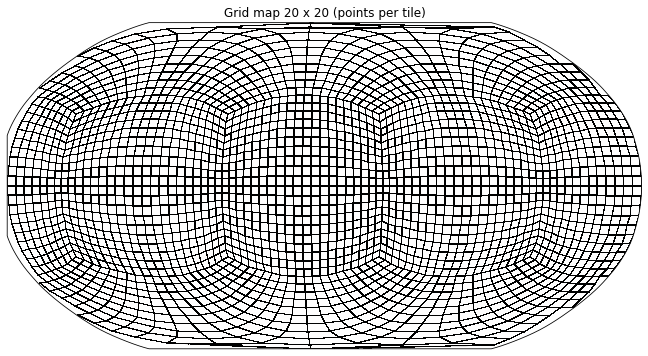

In [10]:
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from fv3viz import pcolormesh_cube

if mpi_rank == 0:
    field = np.zeros(lon_gather.data.shape)[:, :-1, :-1]

    fig = plt.figure(figsize = (12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())

    pcolormesh_cube(lat_gather.data, lon_gather.data, field, 
        cmap="bwr", vmin=-1, vmax=1, edgecolor="k", linewidth=0.1,
    )

    ax.set_title('Grid map %s x %s (points per tile)' % (nx, ny))

    plt.show()

## Retrieving and Plotting More Data

You can use quantities to retrieve any data that is stored inside `grid_data` or any of the other constructed variables, gather it on the root engine and then plot it.

In this case, the area of each grid cell is plotted.

[output:0]

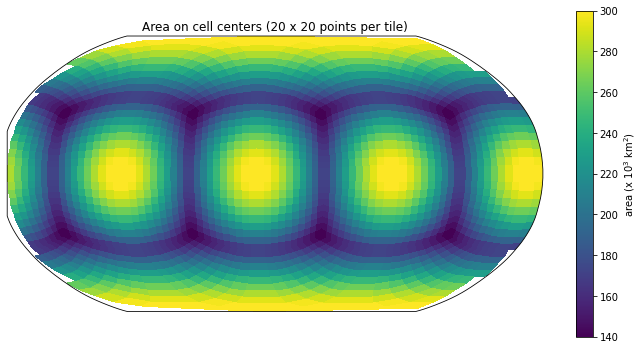

In [11]:
area = Quantity(
    grid_data.area.data,
    dims=("x", "y"),
    units="m2",
    origin=(nhalo, nhalo),
    extent=(nx, ny),
    gt4py_backend=backend,
)

area.data[:] = area.data/(1e6)/1e3 # rescaling for nicer values, now in 10^-3 km2
area_gather = communicator.gather(area)

if mpi_rank == 0:
    
    fig = plt.figure(figsize = (12, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())

    f1 = pcolormesh_cube(lat_gather.data, lon_gather.data, area_gather.data, 
        vmin=140, vmax=300, cmap="viridis"
    )

    plt.colorbar(f1, label="area (x $10^3$ km$^2$)")

    ax.set_title("Area on cell centers (%s x %s points per tile)" % (nx, ny))

    plt.show()

## Recreating this with functions.py

You can reproduce the above steps in a more succinct manner by using the following syntax:

[stderr:2] /home/ajdas/pace/pace-util/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


[stderr:5] /home/ajdas/pace/pace-util/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


[output:0]

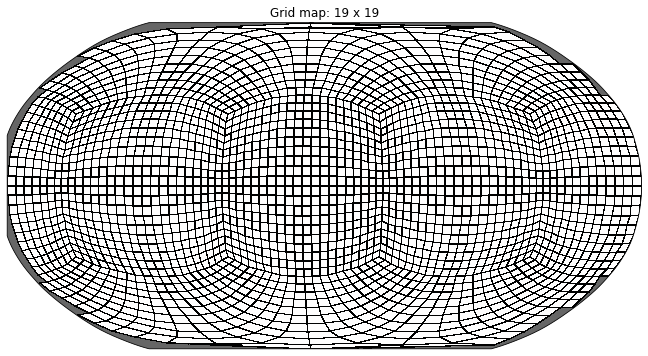

[output:0]

%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

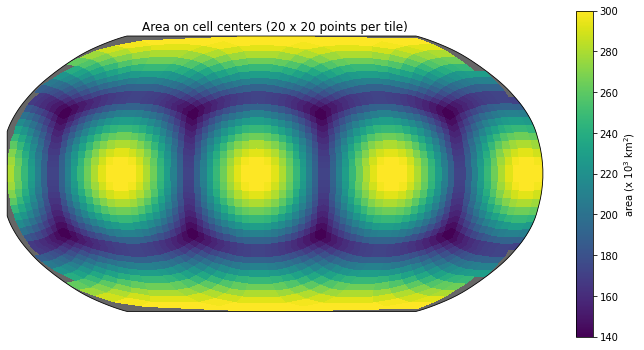

In [12]:
import functions as func
import importlib
importlib.reload(func)

# a little bit of prep
namelistDict = func.store_namelist_variables(locals())
metadata, rank = func.define_metadata(namelistDict, mpi_comm)

# domain decomposition, grid generation, stencil tools
configuration = func.configure_domain(mpi_comm, metadata["dimensions"])

# plot grid
func.plot_grid(configuration, metadata, rank, fOut="grid_map.png", show=True)

# plot area field
plotDict = { "vmin": 140, "vmax": 300, "cmap": "viridis", 
    "units": "area (x $10^3$ km$^2$)", 
    "title": 'Area on cell centers (%s x %s points per tile)' % (nx, ny)
}
func.plot_projection_field(
    configuration, metadata, area_gather, 
    plotDict, mpi_rank, "grid_area.png", show=True
)